In [1]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
# Only get some data to train and test
train_len = 10000
test_len = 1000
x_train = np.reshape(x_train[:train_len], [-1, image_size, image_size, 1])
x_test = np.reshape(x_test[:test_len], [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_test = y_test[:test_len]

In [ ]:
x_train_show = x_train.reshape(-1,28,28)
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train_show[20])
print('y_train[20] = ', y_train[20])

plt.subplot(222)
plt.imshow(x_train_show[500])
print('y_train[500] = ', y_train[500])

plt.subplot(223)
plt.imshow(x_train_show[3000])
print('y_train[3000] = ', y_train[3000])

plt.subplot(224)
plt.imshow(x_train_show[9000])
print('y_train[9000] = ', y_train[9000])
plt.show()

In [3]:
# reparameterization trick: instead of sampling from Q(z|X), sample epsilon = N(0,1)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
def plot_results(encoder, decoder, x_test, y_test, batch_size=128):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

In [5]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30
use_mse = True
load_weights = False

In [6]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [7]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [8]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [9]:
if use_mse:
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                              K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [10]:
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 69076       encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28, 1)    65089       encoder[0][2]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         encoder_input[0][0]              
________________________________________________________________________________________________

In [11]:
if load_weights:
    vae = vae.load_weights(args.weights)
else:
    # train the autoencoder
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    vae.save_weights('vae_cnn_mnist.h5')

Epoch 1/30
313/313 [==============================] - 9s 28ms/step - loss: 85.6508 - val_loss: 49.7185
Epoch 2/30
313/313 [==============================] - 8s 26ms/step - loss: 50.4959 - val_loss: 47.6214
Epoch 3/30
313/313 [==============================] - 9s 29ms/step - loss: 48.7773 - val_loss: 46.5953
Epoch 4/30
184/313 [================>.............] - ETA: 3s - loss: 47.6807

KeyboardInterrupt: 

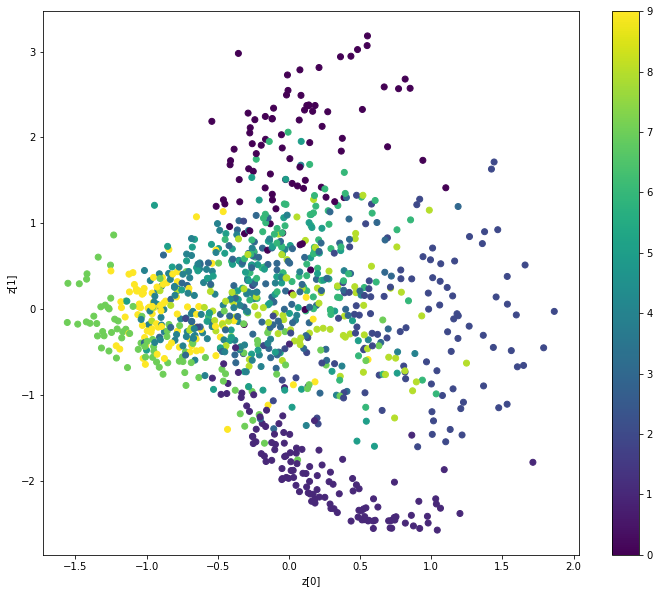

ValueError: The number of FixedLocator locations (31), usually from a call to set_ticks, does not match the number of ticklabels (30).

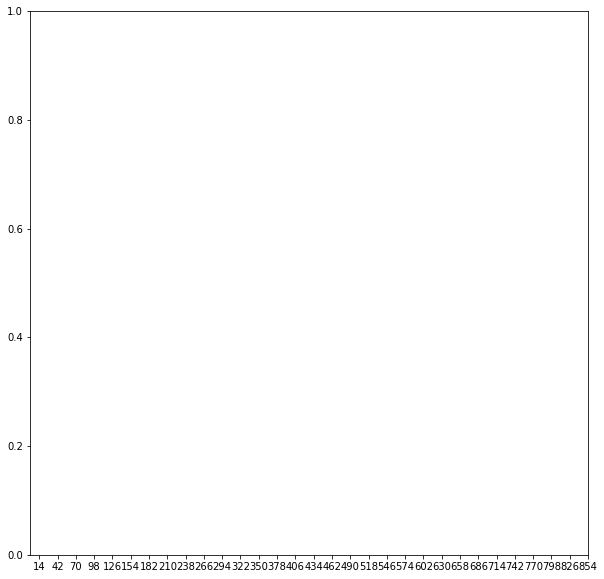

In [12]:
plot_results(encoder, decoder, x_test, y_test, batch_size=batch_size)